# Étude du client 47

In [1]:
#import des librairies
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from joblib import dump

import sys
sys.path.append("../../scripts/")

# librairies perso
from import_data import import_data, import_data_complete
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance

In [2]:
np.random.seed(42)

In [3]:
data = import_data_complete(path = "../../")

In [4]:
# on sélectionne le bon client : 
client = 47
data = data.groupby("id_client").get_group(client)
data = data.reset_index()
data = data.drop(["index", "id_client", "prediction"], axis = 1 )

In [5]:
# création des dossiers utiles
folder1 = f"../../output/client_{client}"
folder2 = f"../../output/client_{client}/modèles"
folder3 = f"../../output/client_{client}/plot"

# Vérifier si les dossier n'existe pas déjà
if not os.path.exists(folder1):
    os.makedirs(folder1)
if not os.path.exists(folder2):
    os.makedirs(folder2)
if not os.path.exists(folder3):
    os.makedirs(folder3)

In [6]:
# création d'un dataFrame où on stocke les résulats
results = pd.DataFrame(columns = ["MSE", "MAE", "R2", "crossVal"])
def concat_results(name, result): 
    df = pd.DataFrame(result, columns = [name], index = results.columns).T
    return pd.concat([results, df])

# Traitement des données

## On enlève les NaN

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   horodate                761 non-null    datetime64[ns]
 1   real_consumption        761 non-null    float64       
 2   forecasted_consumption  761 non-null    float64       
 3   CAC                     761 non-null    float64       
 4   AEX                     761 non-null    float64       
 5   BFX                     761 non-null    float64       
 6   STOXX                   761 non-null    float64       
 7   Airliquide              761 non-null    float64       
 8   gasNat                  761 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 53.6 KB


In [8]:
data.dropna(axis=1, inplace=True)

## On enlève les zéros en trop 

In [9]:
non_zero = np.max(np.where(data["real_consumption"] != 0))
data = data.iloc[:non_zero, :]
data.to_csv(f"../../output/client_{client}/client_{client}.csv")
data

,horodate,real_consumption,forecasted_consumption,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,2021-01-01,4239.00,3000.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
1,2021-01-02,4227.00,3000.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
2,2021-01-03,4227.00,3000.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
3,2021-01-04,4231.00,3000.0,5614.040039,632.020020,3671.080078,3565.679932,123.590912,2.626
4,2021-01-05,4255.12,3000.0,5561.600098,629.940002,3645.760010,3554.239990,123.136360,2.599
...,...,...,...,...,...,...,...,...,...
695,2022-11-27,2054.93,3700.0,6710.359863,721.309998,3703.459961,3962.260010,141.660004,7.332
696,2022-11-28,2100.31,3700.0,6678.109863,716.729980,3697.439941,3952.709961,140.899994,6.870
697,2022-11-29,1973.48,3700.0,6686.959961,723.760010,3681.129883,3941.550049,140.580002,7.319
698,2022-11-30,1239.09,3700.0,6706.669922,721.669983,3685.290039,3945.709961,139.839996,7.264


# Visualisation des données

## Consommation prédite vs consommation réelle

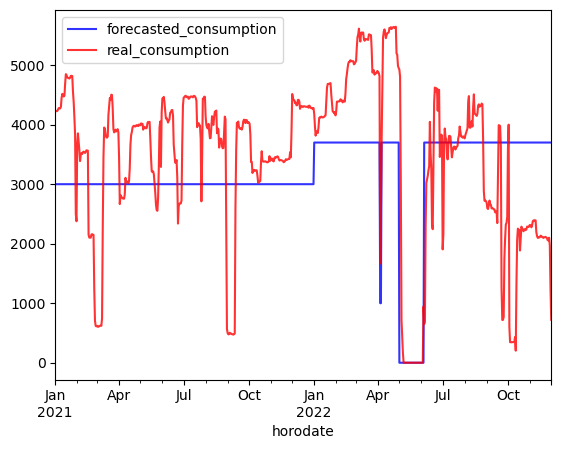

In [10]:
data.plot(x = "horodate", y = ["forecasted_consumption","real_consumption"], color = ["blue", "red"], alpha = 0.8)
plt.savefig(f"../../output/client_{client}/forecasted_vs_real.jpg");

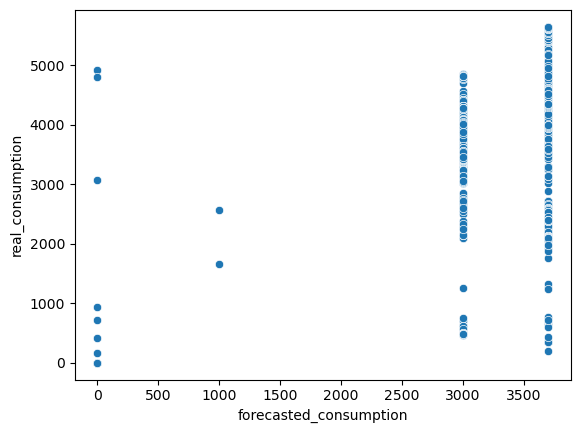

In [11]:
sns.scatterplot(x = "forecasted_consumption", y = "real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_forecasted_vs_real.jpg");

## Etude des corrélations

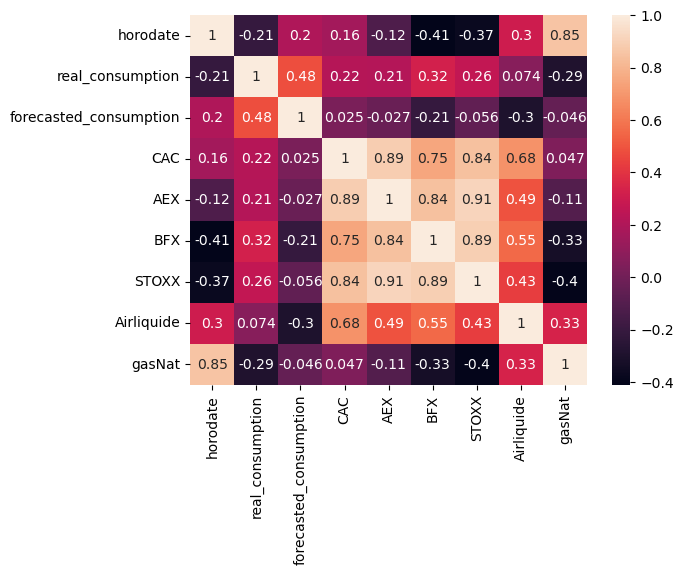

In [12]:
sns.heatmap(data.corr(), annot=True)
plt.savefig(f"../../output/client_{client}/corr.png");

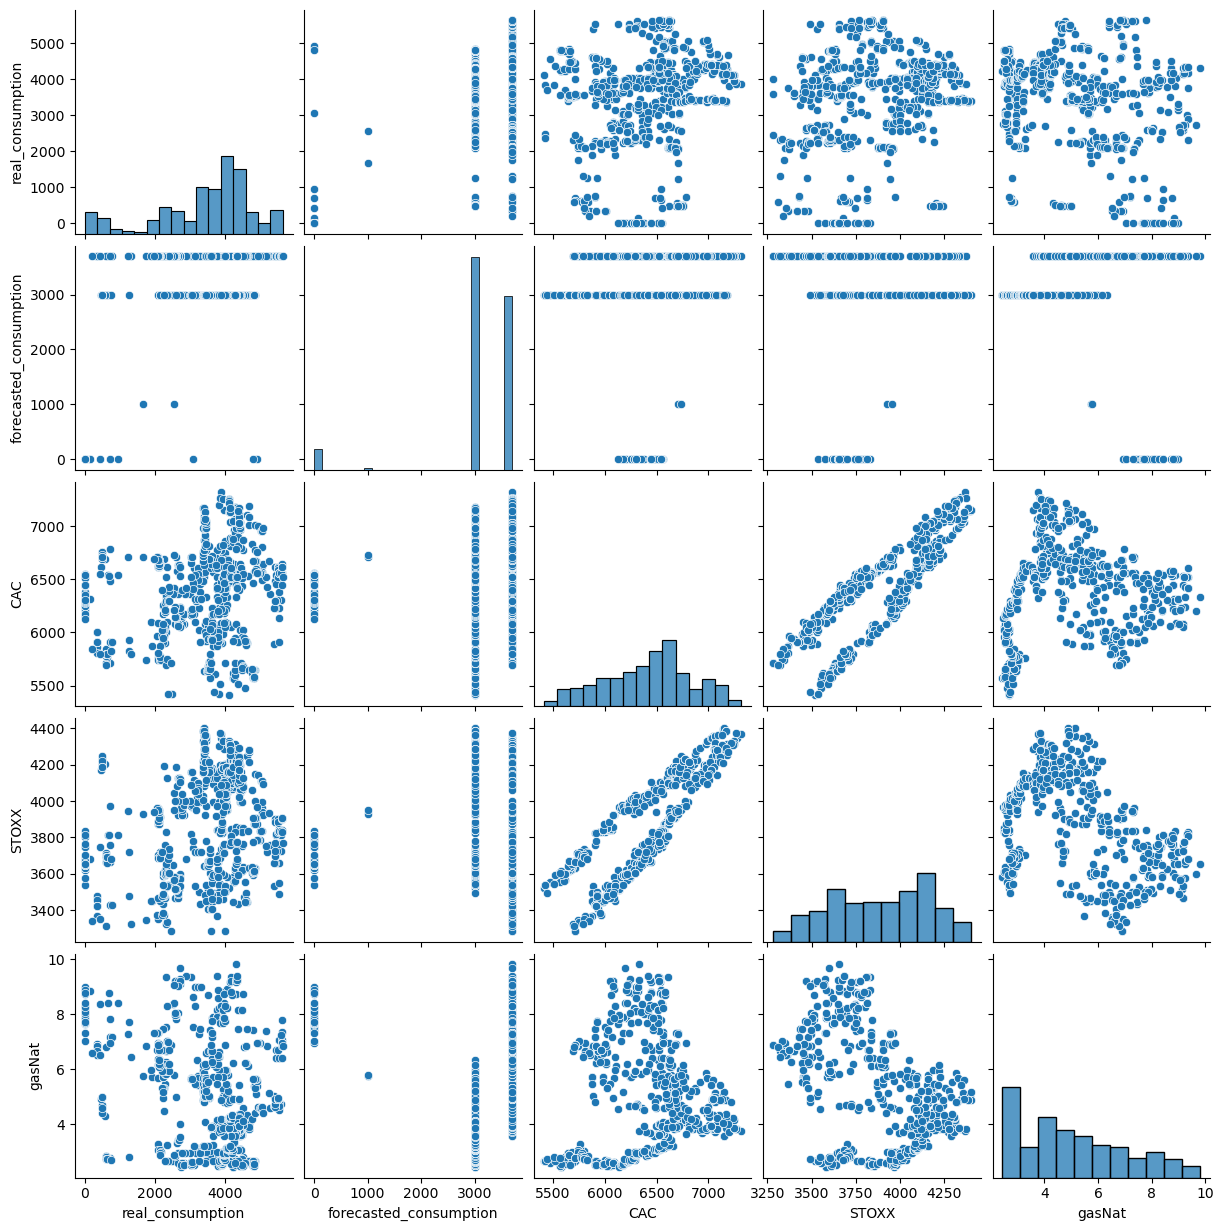

In [13]:
sns.pairplot(data[["real_consumption", "forecasted_consumption", "CAC", "STOXX", "gasNat"]])
plt.savefig(f"../../output/client_{client}/scatter_corr.png");

### CAC

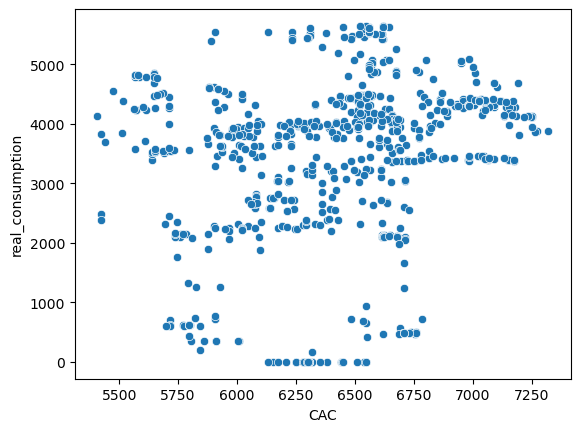

In [14]:
sns.scatterplot(x = "CAC", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_cac_real"); 

### BFX

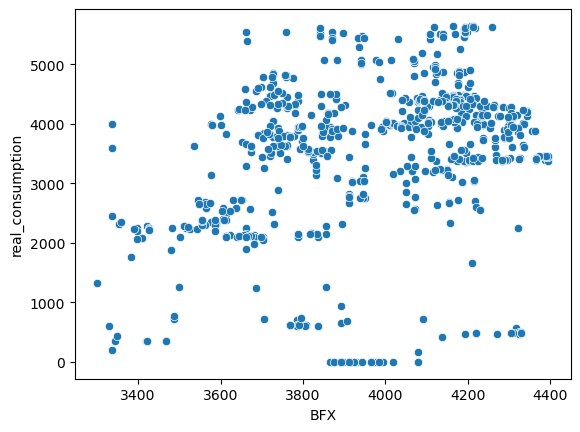

In [15]:
sns.scatterplot(x = "BFX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_bfx_real"); 

### AEX

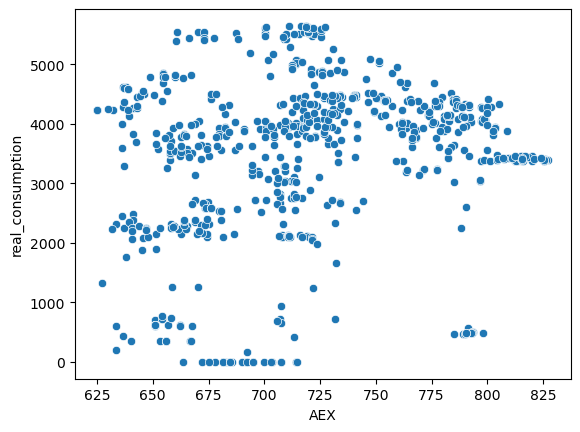

In [16]:
sns.scatterplot(x = "AEX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_aex_real"); 

### STOXX

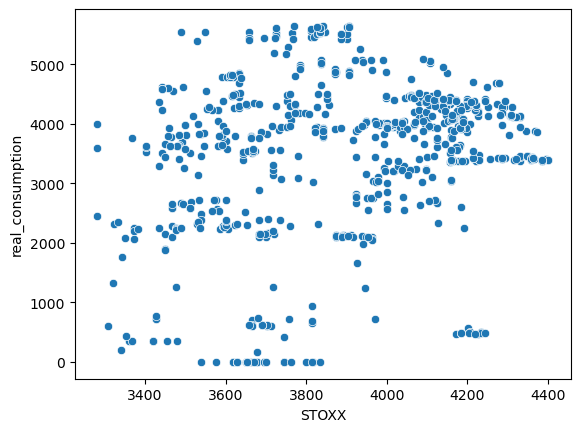

In [17]:
sns.scatterplot(x = "STOXX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_stoxx_real"); 

### Gas naturel

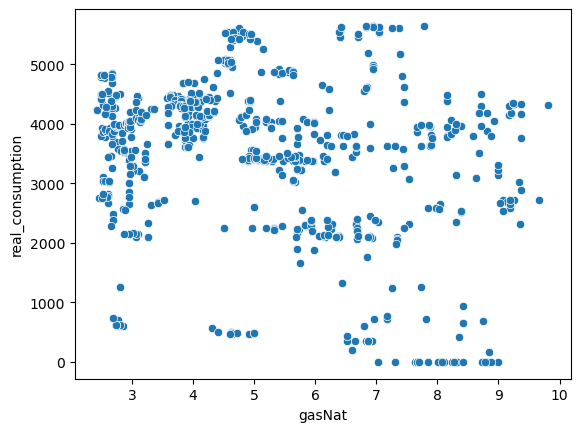

In [18]:
sns.scatterplot(x = "gasNat", y ="real_consumption", data = data)
plt.savefig(f"../../output/client_{client}/scatter_gasNat_real"); 

# Application des modèles

## Modèle 1 : régression linéaire

### Avec une seule variable : forecasted_consumption

In [19]:
# découpage des sets de données
X = data[["forecasted_consumption"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [21]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

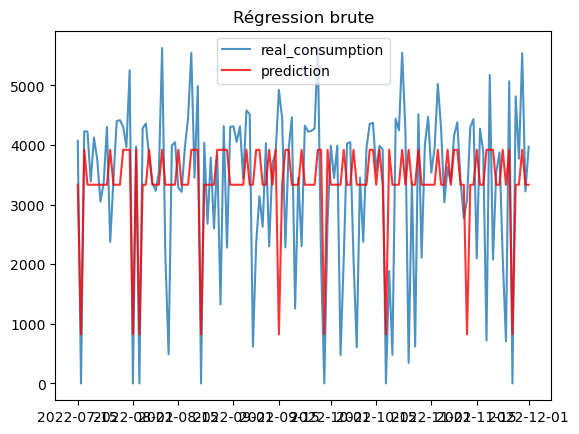

In [22]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression brute")
plt.legend()
plt.savefig(f"../../output/client_{client}/simple_linear_regression.png");

In [23]:
# enregistrement plot
data[["horodate", "real_consumption", "forecasted_consumption"]].rename({"horodate": "time", "real_consumption": "y1", "forecasted_consumption": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot0.csv")
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot1.csv")

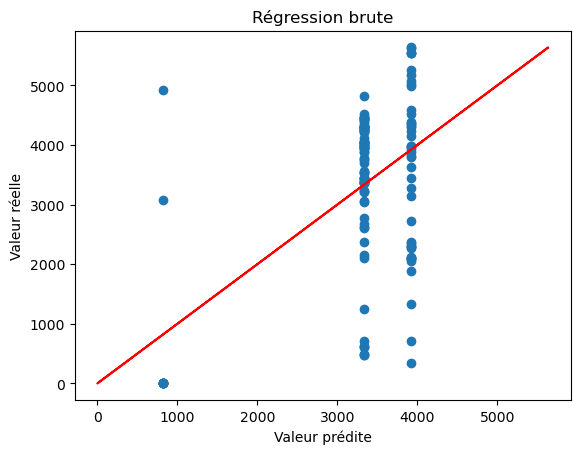

In [24]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Régression brute")
plt.savefig(f"../../output/client_{client}/simple_linear_regression_scatter.png");

#### Erreur de prédiction du client

In [25]:
# erreur entre la consommation réelle et celle prédite par le client
error = [mean_squared_error(y_test, X_test["forecasted_consumption"]), mean_absolute_error(y_test, X_test["forecasted_consumption"]), r2_score(y_test, X_test["forecasted_consumption"])]
error.append(np.NaN)
error

[1736456.05933, 1070.0001428571427, 0.10633302418926549, nan]

In [26]:
results = concat_results("erreur_prediction_client",error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1.736456e+06,1070.000143,0.106333,NaN


#### Erreur du modèle 

In [27]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]

In [28]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
print(f"Validation croisée (r2) : {scores}")

Validation croisée (r2) : [-0.08060119  0.19464835  0.25677766  0.25998676  0.36286556]


In [29]:
#results = concat_results("erreur_regression_simple_train", error_train)
results = concat_results("erreur_regression_simple_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456.05933,1070.000143,0.106333,NaN
erreur_regression_simple_test,1588606.826392,979.155548,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"


In [30]:
# enregistrement du modèle
dump(model, f'../../output/client_{client}/modèles/simple_linear_regression.joblib');

### Avec toutes les données boursières

In [31]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [33]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

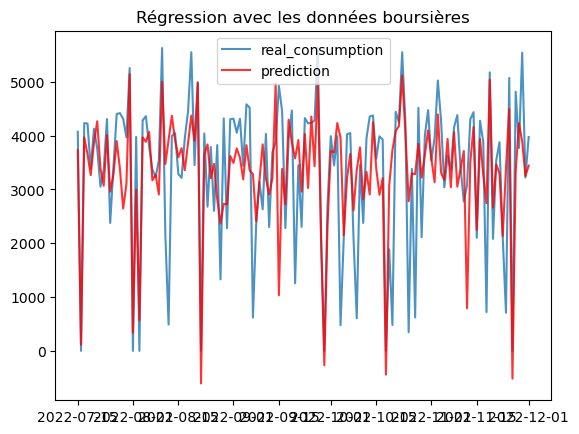

In [34]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression avec les données boursières")
plt.legend()
plt.savefig(f"../../output/client_{client}/complet_linear_regression.png");

In [35]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot2.csv")

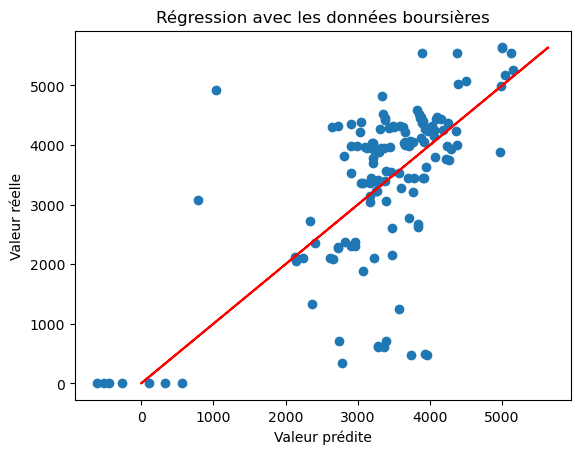

In [36]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Régression avec les données boursières")
plt.savefig(f"../../output/client_{client}/complete_linear_regression_scatter.png");

#### Erreur du modèle 

In [37]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[1116981.7784654994, 737.0312744242373, 0.42514541463138933]

In [38]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.1633217 , 0.53071151, 0.61865449, 0.51721434, 0.5751724 ])

In [39]:
#results = concat_results("erreur_regression_complete_train", error_train)
results = concat_results("erreur_regression_complete_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456.05933,1070.000143,0.106333,NaN
erreur_regression_simple_test,1588606.826392,979.155548,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"
erreur_regression_complete_test,1116981.778465,737.031274,0.425145,"[0.163, 0.531, 0.619, 0.517, 0.575]"


In [40]:
# enregistrement du modèle
dump(model, f'../../output/client_{client}/modèles/complet_linear_regression.joblib');

## Modèle 2 : Random Forest

In [41]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [43]:
# création du modèle
model = RandomForestRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

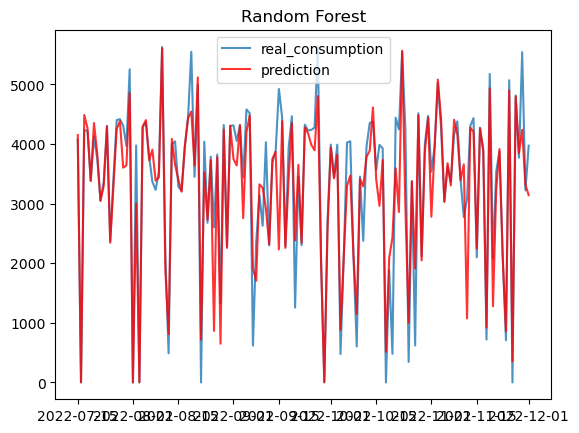

In [44]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Random Forest")
plt.legend()
plt.savefig(f"../../output/client_{client}/random_forest.png");

In [45]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot3.csv")

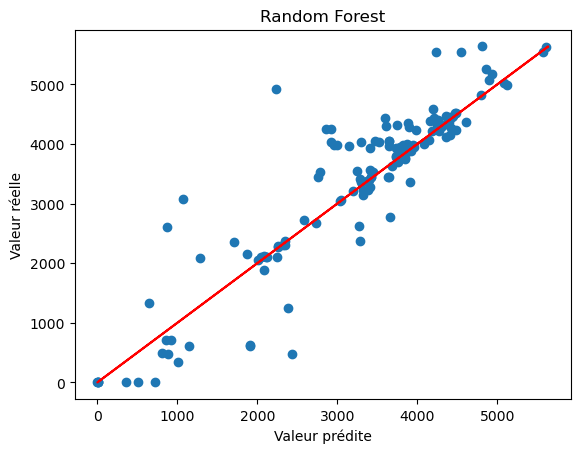

In [46]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Random Forest")
plt.savefig(f"../../output/client_{client}/random_forest_scatter.png");

#### Erreur du modèle

In [47]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[327033.53470218414, 337.41383577933675, 0.8316922168138468]

In [48]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.59160829, 0.86398473, 0.89236835, 0.787574  , 0.83233987])

In [49]:
#results = concat_results("erreur_random_forest_train", error_train)
results = concat_results("erreur_random_forest_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456.05933,1070.000143,0.106333,NaN
erreur_regression_simple_test,1588606.826392,979.155548,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"
erreur_regression_complete_test,1116981.778465,737.031274,0.425145,"[0.163, 0.531, 0.619, 0.517, 0.575]"
erreur_random_forest_test,327033.534702,337.413836,0.831692,"[0.592, 0.864, 0.892, 0.788, 0.832]"


In [50]:
# enregistrement du modèle 
dump(model, f'../../output/client_{client}/modèles/random_forest.joblib');

## Modèle 3 : Gradient Boosting

In [51]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [53]:
# création du modèle
model = GradientBoostingRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

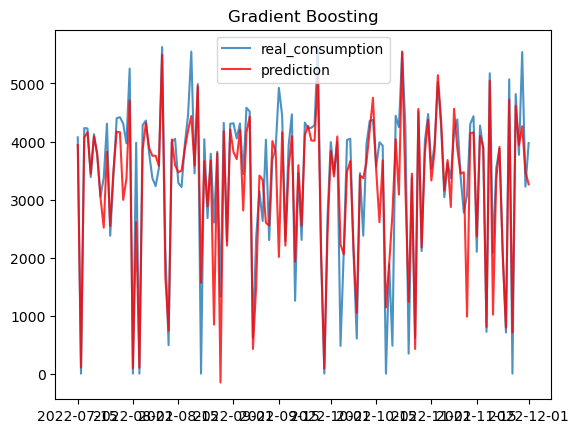

In [54]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Gradient Boosting")
plt.legend()
plt.savefig(f"../../output/client_{client}/gradient_boosting.png");

In [55]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot4.csv")

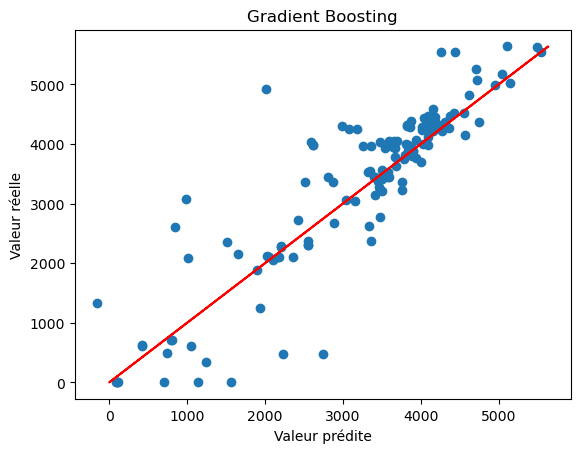

In [56]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Gradient Boosting")
plt.savefig(f"../../output/client_{client}/gradient_boosting_scatter.png");

#### Erreurs du modèle

In [57]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[409953.9148570242, 403.0288401651347, 0.7890172496196612]

In [58]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.52049635, 0.8462674 , 0.91643688, 0.8098429 , 0.85469172])

In [59]:
#results = concat_results("erreur_gradient_boosting_train", error_train)
results = concat_results("erreur_gradient_boosting_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456.05933,1070.000143,0.106333,NaN
erreur_regression_simple_test,1588606.826392,979.155548,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"
erreur_regression_complete_test,1116981.778465,737.031274,0.425145,"[0.163, 0.531, 0.619, 0.517, 0.575]"
erreur_random_forest_test,327033.534702,337.413836,0.831692,"[0.592, 0.864, 0.892, 0.788, 0.832]"
erreur_gradient_boosting_test,409953.914857,403.02884,0.789017,"[0.52, 0.846, 0.916, 0.81, 0.855]"


In [60]:
# enristrement du modèle
dump(model, f"../../output/client_{client}/modèles/gradient_boosting.joblib");

## Modèle 4 : Support vector machine

In [61]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [63]:
"""
# on règle la machine à vecteur de support 
param_grid = {
    'C': [100, 150, 200, 250],
    'kernel': ["poly"],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [1.0, 2.0, 3.0]
}

# Créer le modèle Gradient Boosting
SVM = SVR()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train_norm, y_train)
grid_search.best_estimator_
"""

'\n# on règle la machine à vecteur de support \nparam_grid = {\n    \'C\': [100, 150, 200, 250],\n    \'kernel\': ["poly"],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'degree\': [2, 3, 4],\n    \'coef0\': [1.0, 2.0, 3.0]\n}\n\n# Créer le modèle Gradient Boosting\nSVM = SVR()\n\n# Créer l\'objet GridSearchCV\ngrid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\n# Effectuer la recherche sur grille sur les données d\'entraînement\ngrid_search.fit(X_train_norm, y_train)\ngrid_search.best_estimator_\n'

In [64]:
model = SVR(C=250, coef0=3.0, degree=4, kernel='poly')

In [65]:
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

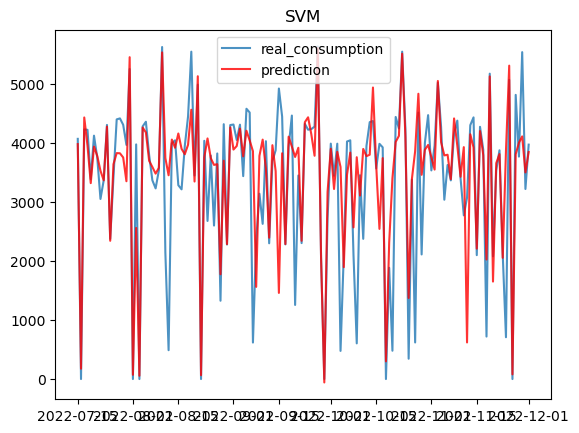

In [66]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("SVM")
plt.legend()
plt.savefig(f"../../output/client_{client}/SVM.png");

In [67]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot5.csv")

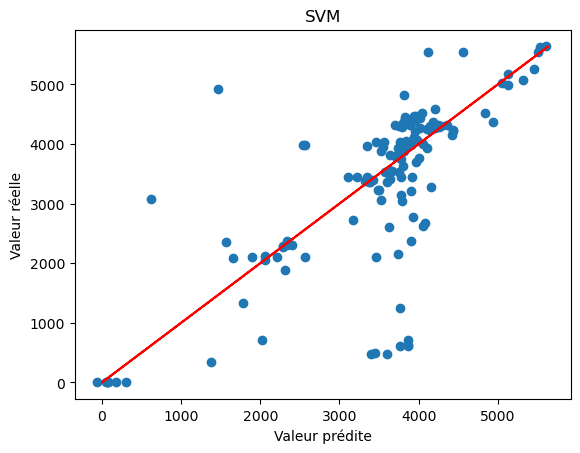

In [68]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("SVM")
plt.savefig(f"../../output/client_{client}/SVM_scatter.png");

#### Erreurs sur le modèle

In [69]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[917439.2614111844, 549.8024104467048, 0.5278399555058627]

In [70]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.31869135, 0.66043868, 0.74347178, 0.66410058, 0.61844131])

In [71]:
#results = concat_results("erreur_SVM_train", error_train)
results = concat_results("erreur_SVM_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456.05933,1070.000143,0.106333,NaN
erreur_regression_simple_test,1588606.826392,979.155548,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"
erreur_regression_complete_test,1116981.778465,737.031274,0.425145,"[0.163, 0.531, 0.619, 0.517, 0.575]"
erreur_random_forest_test,327033.534702,337.413836,0.831692,"[0.592, 0.864, 0.892, 0.788, 0.832]"
erreur_gradient_boosting_test,409953.914857,403.02884,0.789017,"[0.52, 0.846, 0.916, 0.81, 0.855]"
erreur_SVM_test,917439.261411,549.80241,0.52784,"[0.319, 0.66, 0.743, 0.664, 0.618]"


In [72]:
# enregistrement du modèle
dump(model, f"../../output/client_{client}/modèles/SVM.joblib");

## Bruit sur les données boursières

In [73]:
data_perturbation = data.copy()
data_perturbation.describe()

,horodate,real_consumption,forecasted_consumption,CAC,AEX,BFX,STOXX,Airliquide,gasNat
count,700,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.00000
mean,2021-12-16 12:00:00,3450.389271,3142.285714,6418.817785,719.405271,3964.445804,3889.366569,132.445768,5.09686
min,2021-01-01 00:00:00,0.000000,0.000000,5407.740234,625.190002,3301.310059,3282.000000,114.318184,2.43300
25%,2021-06-24 18:00:00,2726.517500,3000.000000,6099.012451,675.890015,3760.934998,3657.932617,127.000000,3.40650
50%,2021-12-16 12:00:00,3835.000000,3000.000000,6489.074951,714.815002,4018.079956,3909.125000,132.830002,4.79550
75%,2022-06-09 06:00:00,4312.250000,3700.000000,6679.450195,761.369980,4177.450073,4123.939941,137.690910,6.60875
max,2022-12-01 00:00:00,5646.040000,3700.000000,7320.479980,827.380005,4395.319824,4400.729980,153.220001,9.81700
std,NaN,1364.155676,806.667798,421.980583,50.686783,255.473421,274.523409,8.160163,1.97792


In [74]:
n = len(data_perturbation)

# pour le CAC
data_perturbation["CAC"] += np.random.normal(0, 100, n)

# pour l'AEX 
data_perturbation["AEX"] += np.random.normal(0,10, n)

# pour le BFX 
data_perturbation["BFX"] += np.random.normal(0, 70, n)

# pour le STOXX 
data_perturbation["STOXX"] += np.random.normal(0,70, n)

# pour le gasNat 
data_perturbation["gasNat"] += np.random.normal(0,0.2, n)

In [75]:
# découpage des sets de données
X = data_perturbation[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data_perturbation["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [77]:
# création du modele 
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

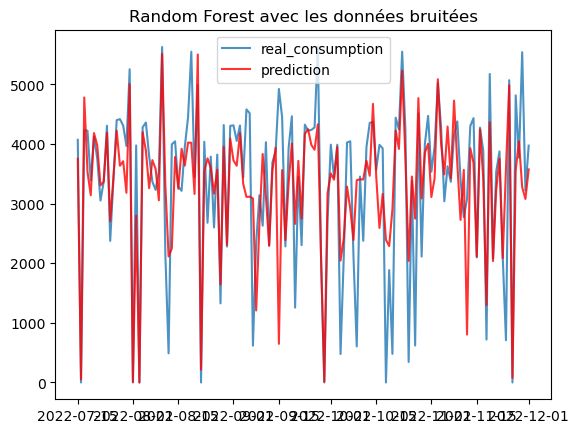

In [78]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Random Forest avec les données bruitées")
plt.legend()
plt.savefig(f"../../output/client_{client}/random_forest_bruit.png");

In [79]:
pd.DataFrame({"time": time.values, "y_test": y_test.values, "y_pred": y_pred}).rename({"y_test": "y1", "y_pred": "y2"}, axis = 1).to_csv(f"../../output/client_{client}/plot/plot6.csv")

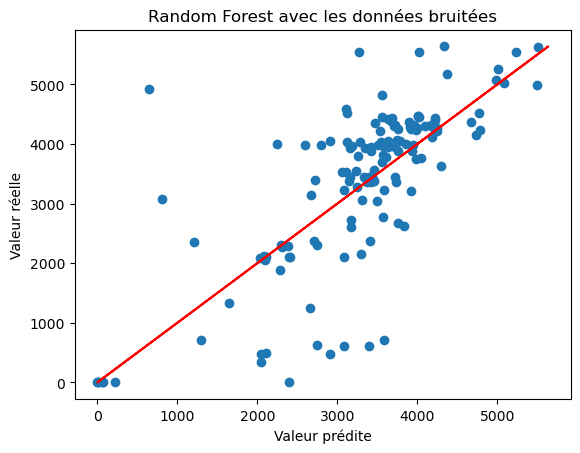

In [80]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Random Forest avec les données bruitées")
plt.savefig(f"../../output/client_{client}/random_forest_scatter_bruit.png");

#### Erreur du modèle 

In [81]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[858327.7214141347, 612.9229128571427, 0.5582617049655416]

In [82]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.24170885, 0.6145041 , 0.72091908, 0.64333548, 0.61323252])

In [83]:
#results = concat_results("erreur_random_forest_bruit_train", error_train)
results = concat_results("erreur_random_forest_bruit_test", error_test)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456.05933,1070.000143,0.106333,NaN
erreur_regression_simple_test,1588606.826392,979.155548,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"
erreur_regression_complete_test,1116981.778465,737.031274,0.425145,"[0.163, 0.531, 0.619, 0.517, 0.575]"
erreur_random_forest_test,327033.534702,337.413836,0.831692,"[0.592, 0.864, 0.892, 0.788, 0.832]"
erreur_gradient_boosting_test,409953.914857,403.02884,0.789017,"[0.52, 0.846, 0.916, 0.81, 0.855]"
erreur_SVM_test,917439.261411,549.80241,0.52784,"[0.319, 0.66, 0.743, 0.664, 0.618]"
erreur_random_forest_bruit_test,858327.721414,612.922913,0.558262,"[0.242, 0.615, 0.721, 0.643, 0.613]"


In [84]:
# enregistrement du modèle
dump(model, f"../../output/client_{client}/modèles/random_forest_bruit.joblib");

## Gradient Boosting avec xgboost

In [85]:
import xgboost as xgb

In [86]:
# découpage des sets de données
X = data_perturbation[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data_perturbation["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [88]:
params = {
    'objective': 'reg:squarederror',  # Pour un problème de régression
    'eval_metric': 'rmse',  # Métrique d'évaluation : erreur quadratique moyenne
    'eta': 0.1,  # Taux d'apprentissage (learning rate)
    'max_depth': 5,  # Profondeur maximale de l'arbre
    'min_child_weight': 1,  # Poids minimum d'un exemple pour créer un nouveau nœud
    'gamma': 0,  # Paramètre de régularisation pour la réduction de l'erreur
    'subsample': 0.8,  # Taux d'échantillonnage des exemples pour la construction d'arbres
    'colsample_bytree': 0.8,  # Taux d'échantillonnage des caractéristiques pour la construction d'arbres
    'seed': 42  # Graine aléatoire pour la reproductibilité
}

In [89]:
model = xgb.XGBRegressor(**params)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

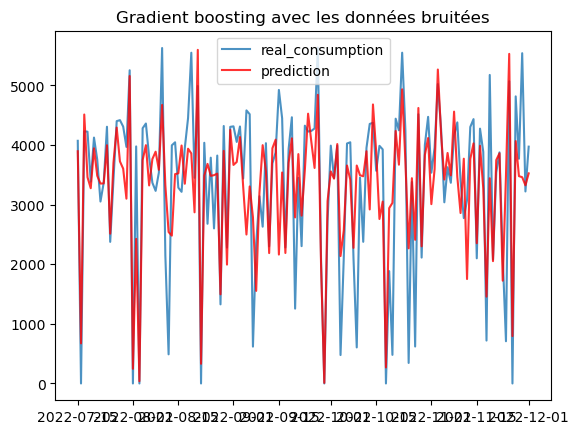

In [90]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Gradient boosting avec les données bruitées")
plt.legend()
plt.savefig(f"../../output/client_{client}/xgboost_bruit.png");

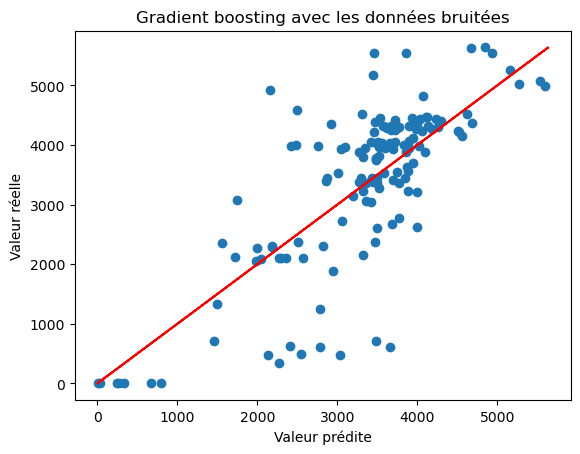

In [91]:
plt.scatter(y_pred, y_test)
plt.plot(y_test, y_test, color = "r")
plt.xlabel("Valeur prédite")
plt.ylabel("Valeur réelle")
plt.title("Gradient boosting avec les données bruitées")
plt.savefig(f"../../output/client_{client}/xgboost_scatter_bruit.png");

#### Erreur du modèle 

In [92]:
# erreur sur le test / train
error_test = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error_train = [mean_squared_error(y_train, model.predict(X_train_norm)), mean_absolute_error(y_train, model.predict(X_train_norm)), r2_score(y_train, model.predict(X_train_norm))]
error_test

[776550.0545772233, 624.4421795003074, 0.6003485748395763]

In [93]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error_test.append(np.round(scores, decimals=3))
error_train.append(np.nan)
scores

array([0.21814365, 0.64467073, 0.67588198, 0.60816148, 0.59994963])

In [94]:
#results = concat_results("xgb_bruit_train", error_train)
results = concat_results("xbg_bruit_test", error_test)
results[["MSE", "MAE"]] = results[["MSE", "MAE"]].astype(int)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,1736456,1070,0.106333,NaN
erreur_regression_simple_test,1588606,979,0.182424,"[-0.081, 0.195, 0.257, 0.26, 0.363]"
erreur_regression_complete_test,1116981,737,0.425145,"[0.163, 0.531, 0.619, 0.517, 0.575]"
erreur_random_forest_test,327033,337,0.831692,"[0.592, 0.864, 0.892, 0.788, 0.832]"
erreur_gradient_boosting_test,409953,403,0.789017,"[0.52, 0.846, 0.916, 0.81, 0.855]"
erreur_SVM_test,917439,549,0.52784,"[0.319, 0.66, 0.743, 0.664, 0.618]"
erreur_random_forest_bruit_test,858327,612,0.558262,"[0.242, 0.615, 0.721, 0.643, 0.613]"
xbg_bruit_test,776550,624,0.600349,"[0.218, 0.645, 0.676, 0.608, 0.6]"


In [95]:
# enregistrement du modèle
dump(model, f"../../output/client_{client}/modèles/xgboost_bruit.joblib");

In [96]:
# enregistrement des résultats 
results.to_csv(f"../../output/client_{client}/results.csv")